In [267]:
from pymongo import MongoClient
from collections import Counter
from pandas import DataFrame
from statistics import mean
import matplotlib.ticker as mtick

# Experiment 1

Binary classification metrics on line-level. Separate files by file type.

In [268]:
def get_confusion_counts_by_file_type_pytheas(file_type):
    with MongoClient() as mongo:
        db = mongo['master']
        return Counter([*db['files'].aggregate([
            {
                '$match': {
                    'incomplete': {
                        '$exists': False
                    }
                }
            }, {
                '$lookup': {
                    'from': 'metrics', 
                    'let': {
                        'fileId': {
                            '$toString': '$_id'
                        }
                    }, 
                    'pipeline': [
                        {
                            '$match': {
                                '$expr': {
                                    '$eq': [
                                        '$fileId', '$$fileId'
                                    ]
                                }, 
                                'parser': 'rfc4180'
                            }
                        }
                    ], 
                    'as': 'metrics'
                }
            }, {
                '$unwind': {
                    'path': '$metrics'
                }
            }, {
                '$match': {
                    'metrics.fileMetrics_fileType': file_type
                }
            }, {
                '$lookup': {
                    'from': 'pytheas', 
                    'let': {
                        'fileId': {
                            '$toString': '$_id'
                        }
                    }, 
                    'pipeline': [
                        {
                            '$match': {
                                '$expr': {
                                    '$eq': [
                                        '$fileId', '$$fileId'
                                    ]
                                }
                            }
                        }
                    ], 
                    'as': 'pytheas'
                }
            }, {
                '$unwind': {
                    'path': '$pytheas'
                }
            }, {
                '$match': {
                    'pytheas.status': 'success'
                }
            }, {
                '$group': {
                    '_id': None, 
                    'false, false': {
                        '$sum': '$pytheas.metrics_(False, False)'
                    }, 
                    'false, true': {
                        '$sum': '$pytheas.metrics_(False, True)'
                    }, 
                    'true, false': {
                        '$sum': '$pytheas.metrics_(True, False)'
                    }, 
                    'true, true': {
                        '$sum': '$pytheas.metrics_(True, True)'
                    }
                }
            }
        ])][0])

In [269]:
def get_confusion_counts_by_file_type_tableExtractor(file_type):
    with MongoClient() as mongo:
        db = mongo['master']
        return Counter([*db['metrics'].aggregate([
            {
                '$match': {
                    'parser': 'tableExtractor',
                    'fileMetrics_fileType': file_type,
                    'fileMetrics_incomplete': False,
                    'status': 'success'
                }
            },{
                '$group': {
                    '_id': None,
                    'false, false': {'$sum': '$lineMetrics_confusion_(False, False)'},
                    'false, true': {'$sum': '$lineMetrics_confusion_(False, True)'},
                    'true, false': {'$sum': '$lineMetrics_confusion_(True, False)'},
                    'true, true': {'$sum': '$lineMetrics_confusion_(True, True)'}
                }
            }
        ])][0])

In [286]:
def compute_classification_metrics(confusion_counts):
    precision = confusion_counts['true, true'] / (confusion_counts['true, true'] + confusion_counts['true, false'])
    recall = confusion_counts['true, true'] / (confusion_counts['true, true'] + confusion_counts['false, true'])
    print((confusion_counts['true, true'] / (confusion_counts['true, true'] + confusion_counts['false, true'])))
    print((confusion_counts['false, false'] / (confusion_counts['false, false'] + confusion_counts['true, false'])))
    return {
        'accuracy': round((confusion_counts['true, true'] + confusion_counts['false, false']) / (confusion_counts['false, false'] + confusion_counts['false, true'] + confusion_counts['true, false'] + confusion_counts['true, true']), 3),
        'precision': round(precision, 3),
        'recall': round(recall, 3),
        'f1': round((2 * precision * recall) / (precision + recall), 3),
        'balancedAcc': round(((confusion_counts['true, true'] / (confusion_counts['true, true'] + confusion_counts['false, true'])) + (confusion_counts['false, false'] / (confusion_counts['false, false'] + confusion_counts['true, false']))) / 2, 3)
    }

In [287]:
compute_classification_metrics(complex_multi_confusion_counts)

0.9971813725490196
0.594920634920635


{'accuracy': 0.951,
 'precision': 0.95,
 'recall': 0.997,
 'f1': 0.973,
 'balancedAcc': 0.796}

In [271]:
def compute_all_true_metrics(confusion_counts):
    return compute_classification_metrics(Counter({
        'true, true': confusion_counts['true, true'] + confusion_counts['false, true'],
        'true, false': confusion_counts['true, false'] + confusion_counts['false, false']
    }))

In [289]:
simple_confusion_counts = get_confusion_counts_by_file_type_tableExtractor('simple')
complex_single_confusion_counts = get_confusion_counts_by_file_type_tableExtractor('complex_single')
complex_multi_confusion_counts = get_confusion_counts_by_file_type_tableExtractor('complex_multi')
DataFrame([
    {'fileType': 'simple', 'subject': 'tableExtractor', **compute_classification_metrics(simple_confusion_counts)},
    {'fileType': 'simple', 'subject': 'pytheas', **compute_classification_metrics(get_confusion_counts_by_file_type_pytheas('simple'))},
    {'fileType': 'simple', 'subject': 'allTable', **compute_all_true_metrics(simple_confusion_counts)},
    {'fileType': 'complex-single', 'subject': 'tableExtractor', **compute_classification_metrics(complex_single_confusion_counts)},
    {'fileType': 'complex-single', 'subject': 'pytheas', **compute_classification_metrics(get_confusion_counts_by_file_type_pytheas('complex_single'))},
    {'fileType': 'complex-single', 'subject': 'allTable', **compute_all_true_metrics(complex_single_confusion_counts)},
    {'fileType': 'complex-multi', 'subject': 'tableExtractor', **compute_classification_metrics(complex_multi_confusion_counts)},
    {'fileType': 'complex-multi', 'subject': 'pytheas', **compute_classification_metrics(get_confusion_counts_by_file_type_pytheas('complex_multi'))},
    {'fileType': 'complex-multi', 'subject': 'allTable', **compute_all_true_metrics(complex_multi_confusion_counts)}
])

0.9985757208872914
1.0
1.0
0.8886198547215496
1.0
0.0
0.997319465177124
0.9769507533168428
0.9898071151888526
0.8279048665170257
1.0
0.0
0.9971813725490196
0.594920634920635
0.9409054715049482
0.33302857142857145
1.0
0.0


,fileType,subject,accuracy,precision,recall,f1,balancedAcc
0,simple,tableExtractor,0.999,1.000,0.999,0.999,0.999
1,simple,pytheas,0.999,0.999,1.000,1.000,0.944
2,simple,allTable,0.999,0.999,1.000,0.999,0.500
3,complex-single,tableExtractor,0.995,0.997,0.997,0.997,0.987
4,complex-single,pytheas,0.932,0.912,0.990,0.949,0.909
5,complex-single,allTable,0.897,0.897,1.000,0.946,0.500
6,complex-multi,tableExtractor,0.951,0.950,0.997,0.973,0.796
7,complex-multi,pytheas,0.739,0.739,0.941,0.828,0.637
8,complex-multi,allTable,0.886,0.886,1.000,0.940,0.500


*Note* 'alltable' refers to all other solutions, as each of them only returns one dialect and we assume they return a single table that cover all lines.

*Note 2* Some algorithms actually do make some selection, which lines are part of a table and which ones are not (while still returning only a single table per file). However, they don't make this information directly accessible, they only offer a solution to return the extracted table right away. There is no way of getting the range indexes without applying some line matching, which is error-prone.

*Note 3*
Most lines are data lines, which is especially true for single tables files. That's why we introduced balanced accuracy which will be lower if one of the classes table-line/ non-table-line are not performing well. In complex-multi files 5.5\% of the lines are not table lines. On one-hand side that even such files contain a lot of valuable information. On the other hand side it becomes harder to optimize algorithm to separate between the two classes. Balanced accuracy of tableExtractor 0.783 is 0.998 table and 0.567 not-table. Meaning, we rarely loose data, but we often interpret non-table lines as table. This could be because of table-like structures with such files that are no actual data tables.

Of course pytheas is not optimized for ascii tables. but we expected that it would capture them as they do not look like text.

# Experiment 2

How many tables have been classified correctly to X percent?

In [22]:
def get_table_coverages_of_table_extractor(success_only):
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    'parser': 'tableExtractor', 
                    'fileMetrics_incomplete': False, 
                    **({'status': 'success'} if success_only else {})
                }
            }, {
                '$unwind': {
                    'path': '$tableMetrics_tables'
                }
            }, {
                '$addFields': {
                    'coverage': {
                        '$divide': [
                            '$tableMetrics_tables.confusion.(True, True)', '$tableMetrics_tables.rowCount'
                        ]
                    }
                }
            }, {
                '$project': {
                    'coverage': True,
                    'fileId': True,
                    '_id': False
                }
            }
        ])

In [23]:
def get_table_coverages_of_pytheas(success_only):
    with MongoClient() as mongo:
        db = mongo['master']
        return db['pytheas'].aggregate([
            {
                '$match': {
                    'incomplete': False, 
                    **({'status': 'success'} if success_only else {})
                }
            }, {
                '$unwind': {
                    'path': '$metrics_tables'
                }
            }, {
                '$project': {
                    'coverage': '$metrics_tables.coverage',
                    'fileId': True,
                    '_id': False
                }
            }
        ])

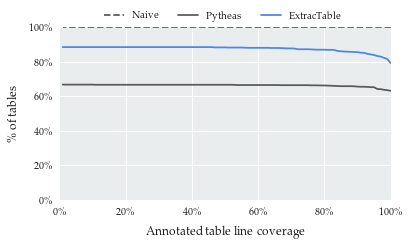

In [35]:
table_coverages_table_extractor_all = [*get_table_coverages_of_table_extractor(False)]
table_coverages_pytheas_all = [*get_table_coverages_of_pytheas(False)]

df = DataFrame([
    {
        'coverage': coverage_level,
        'Naive': 1,
        'Pytheas': mean((coverage['coverage'] or 0) >= coverage_level for coverage in table_coverages_pytheas_all),
        'ExtracTable': mean((coverage['coverage'] or 0) >= coverage_level for coverage in table_coverages_table_extractor_all),
    }
    for coverage_level in (round(v * 0.01, 2) for v in range(100, 0, -1))
])

ax = df.plot(
    kind='line',
    x='coverage',
#     stacked=False,
    color=['#595959', '#595959', '#4A86E8'],
    style=['--', '', '']
)
ax.set(
    xlabel='Annotated table line coverage', 
    ylabel='\% of tables',
    ylim=(0, 1.0),
    xlim=(0, 1.0)
)
ax.get_xaxis().set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.get_yaxis().set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.legend(loc='lower center', bbox_to_anchor=(0, 0.98, 0.98, 0), ncol=3)
plt.tight_layout()
ax.get_figure().savefig('table-coverage')

In [285]:
mean((coverage['coverage'] or 0) >= 1 for coverage in table_coverages_table_extractor_all)

0.7922185430463576

- total number of tables: 1119
- 567 simple files
- 245 complex_simple files
- 61 complex_multi files

# Experiment 3

If a line was not detected as table line (False Negative) what row types does this line have? How does the ratio look like compared to the row type count in the GT?

In [276]:
def get_row_type_totals():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['lines'].aggregate([
            {
                '$lookup': {
                    'from': 'metrics', 
                    'let': {
                        'fileId': '$fileId'
                    }, 
                    'pipeline': [
                        {
                            '$match': {
                                '$expr': {
                                    '$eq': [
                                        '$fileId', '$$fileId'
                                    ]
                                }, 
                                'parser': 'tableExtractor', 
                                'status': 'success', 
                                'fileMetrics_incomplete': False
                            }
                        }
                    ], 
                    'as': 'metric'
                }
            }, {
                '$unwind': {
                    'path': '$metric'
                }
            }, {
                '$match': {
                    'metric': {
                        '$exists': True
                    }
                }
            }, {
                '$group': {
                    '_id': '$rowType', 
                    'count': {
                        '$sum': 1
                    }
                }
            }
        ])

In [277]:
def get_missing_row_types():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    'fileMetrics_incomplete': False, 
                    'status': 'success', 
                    'parser': 'tableExtractor'
                }
            }, {
                '$group': {
                    '_id': None, 
                    'data': {
                        '$sum': '$lineMetrics_missingTypes_data'
                    }, 
                    'header': {
                        '$sum': '$lineMetrics_missingTypes_header'
                    }, 
                    'other': {
                        '$sum': '$lineMetrics_missingTypes_other'
                    }
                }
            }, {
                '$project': {
                    '_id': False,
                    'data': True,
                    'header': True,
                    'other': True
                }
            }
        ])

row_type_totals
```
[{'_id': 'data', 'count': 924701},
 {'_id': 'header', 'count': 785},
 {'_id': None, 'count': 40393},
 {'_id': 'other', 'count': 237}]
 ```

In [278]:
row_type_totals = [*get_row_type_totals()]  # slow!
line_count = sum(row_type_total['count'] for row_type_total in row_type_totals)
row_type_total_shares = {
    row_type_total['_id']: row_type_total['count'] / line_count
    for row_type_total in row_type_totals
}

missing_row_types
```
{'data': 1821, 'header': 75, 'other': 53}
```

In [279]:
# missing_row_types = [*get_missing_row_types()][0]
# line_count = sum(missing_row_types.values())
missing_row_type_shares = {
    row_type: count / line_count
    for row_type, count in missing_row_types.items()
}

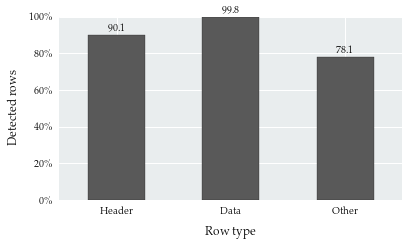

In [280]:
df = DataFrame(
    [
        {
            'type': row_type.capitalize(),
            'Detected': (row_type_total_shares.get(row_type, 0) - missing_row_type_shares.get(row_type, 0)) / row_type_total_shares.get(row_type, 0)
        }
        for row_type in ['header', 'data', 'other']
    ], 
)

ax = df.plot(
    kind='bar',
    x='type',
    color=['#595959'],
    edgecolor='#1B1B1B',
    rot=0,
    legend=False
)
ax.set(
    xlabel='Row type', 
    ylabel='Detected rows',
    ylim=(0,1)
)
ax.get_yaxis().set_major_formatter(mtick.PercentFormatter(xmax=1.0))

for p in ax.patches:
    ax.annotate(
        round(p.get_height() * 100, 1),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',                              
        va='center',                              
        xytext=(0, 5),                               
        textcoords='offset points',
        fontsize=10
    )
plt.tight_layout()
ax.get_figure().savefig('missing-line-types')

# Experiment 4

How many files have table classification accuracy > X percent? Serparate datasets per file type.

In [19]:
def get_confusion_counts_per_file_type():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    'parser': 'tableExtractor', 
                    'fileMetrics_incomplete': False, 
                    'status': 'success'
                }
            }, {
                '$group': {
                    '_id': '$fileMetrics_fileType', 
                    'confusion': {
                        '$push': {
                            'false, false': '$lineMetrics_confusion_(False, False)', 
                            'false, true': '$lineMetrics_confusion_(False, True)', 
                            'true, false': '$lineMetrics_confusion_(True, False)', 
                            'true, true': '$lineMetrics_confusion_(True, True)'
                        }
                    }
                }
            }
        ])

In [20]:
# https://stackoverflow.com/questions/16259923/how-can-i-escape-latex-special-characters-inside-django-templates
import re

def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

Text(0, 0.5, 'percentage of files')

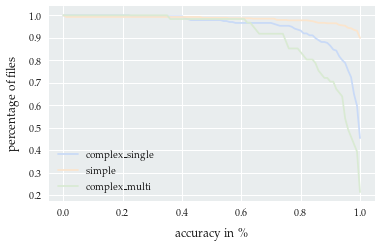

In [21]:
def get_accuracy_from_confusion(confusion):
    return (confusion.get('true, true', 0) + confusion.get('false, false', 0)) / (confusion.get('false, false', 0) + confusion.get('false, true', 0) + confusion.get('true, false', 0) + confusion.get('true, true', 0)) 

accuracies_per_type = [
    {
        'fileType': confusions_per_file_type['_id'],
        'accuracies': [get_accuracy_from_confusion(confusion) for confusion in confusions_per_file_type['confusion']]
    }
    for confusions_per_file_type in get_confusion_counts_per_file_type()
]

axis = DataFrame([
    {
        'percentage': percentage,
        **{
            tex_escape(accuracies['fileType']): mean(accuracy >= percentage for accuracy in accuracies['accuracies'])
            for accuracies in accuracies_per_type
        }
    }
    for percentage in (round(v * 0.01, 2) for v in range(100, -1, -1))
]).plot(x='percentage')
axis.set_xlabel('accuracy in \%')
axis.set_ylabel('percentage of files')